In [1]:
import sys
import pickle
import os.path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
#import math
#from scipy.spatial.transform import Rotation as R
import ext_model


In [2]:
fmodel="ext_model2D.pickle"
if os.path.isfile(fmodel):
    print("Using existing model")
    newmodel = 0
else:
    newmodel = 1 #set to zero
    print("Creating new model")
    

Using existing model


In [3]:
# Create new model
if newmodel==1:    
    model = ext_model.extmy_model(100)
    #print(model.rho,model.a1)
    with open(fmodel,"wb") as file:
        pickle.dump(model,file)
        file.close()

In [4]:
### CLASS TO STORE A GIVEN MODEL
class extmy_model:
    def __init__(self,N):
        self.rho = np.random.rand(N)*0.1 # core density
        self.x0 = np.random.rand(N)*8.-4. # cartesian location of cloud [-4,4] kpc
        self.y0 = np.random.rand(N)*8.-4. # cartesian location of cloud [-4,4] kpc
        self.z0 = np.random.rand(N)-0.5   # cartesian location od cloud [-0.5,0.5] kpc
        self.s1 = 0.05+np.random.rand(N)*0.05 # size along axis kpc
        self.s2 = 0.05+np.random.rand(N)*0.05
        self.s3 = 0.05+np.random.rand(N)*0.05
        self.a1 = np.random.rand(N)*60.-30. # orientation [-30,30] deg
        self.a2 = np.random.rand(N)*90.-45. # orientation [-45,45] deg

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.rho)


In [5]:
# Load model
with open(fmodel,"rb") as file:
    model = pickle.load(file)
    file.close()

In [6]:
X,Y = np.mgrid[-5:5.1:0.1, -5:5.1:0.1]
dens = X*0.

for i in range(len(X[:,1])):
    for j in range(len(X[1,:])):
        dens[i,j] = ext_model.ext_model(X[i,j],Y[i,j],0.,model)



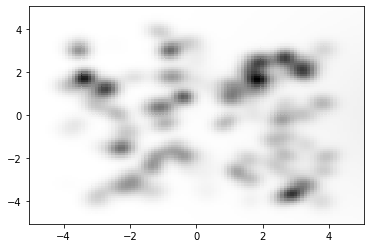

In [7]:
plt.pcolormesh(X, Y, dens, shading='auto', cmap=plt.cm.gist_yarg)
plt.show()



In [8]:
dtype = torch.float
#device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("cpu") # Uncomment this to run on CPU
print(device)

cpu


In [16]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

results=[]
pool = mp.Pool(mp.cpu_count())

# call back function for asynchroneous parallel processing
def collect_result(result):
    global results
    results.append(result)

    

Number of processors:  20


In [17]:
# define a training sample of n points -> using 3D model to construct 2D model
n=20000
ell = torch.rand(n,device=device)*360.
b = torch.zeros(n,device=device,dtype=dtype)
dist = torch.rand(n,device=device)*5.5

K = torch.zeros(n,device=device,dtype=dtype)
error = torch.zeros(n,device=device,dtype=dtype)


print("Start processing")
# use loop for parallel processing  
for i in range(n):
    pool.apply_async(ext_model.integ_d_async, args=(i,ext_model.ext_model,ell[i].data,b[i].data,dist[i].data,model),callback=collect_result)

# close pool
pool.close()
pool.join() # wait for all processes to be completed 

# sort the result
print("Sorting results")
results.sort(key=lambda x: x[0])
K = [r for i,r in results]

print("Adding errors")
for i in range(n):
    error[i] = K[i].item()*np.random.uniform(low=0.01,high=0.1)
    K[i] = K[i].item()+np.random.normal(scale=error[i].item())



Start processing
Sorting results
Adding errors


In [18]:
# Class to store the date to be used with minibatch
class MyDataset2D(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, ell, dist, K, error):
        'Initialization'
        #self.list_IDs  = np.arange(len(ell))
        self.ell = ell
        self.cosell = np.cos(self.ell*np.pi/180.)
        self.sinell = np.sin(self.ell*np.pi/180.)
        self.dist = dist # distance in kpc
        self.K = K # total Absorption
        self.error = error # error on absorption

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ell)

    def __getitem__(self, index): ### Not sure this is how I should do it
        'Generates one sample of data'
        return torch.tensor((self.cosell[index],self.sinell[index],self.dist[index])), torch.tensor((self.K[index],self.error[index]))



In [19]:
# prepares the dataset used for training
dataset = MyDataset2D(ell, dist, K, error)
torch.save(dataset,"fiducial_model2D.pt")
